<a href="https://colab.research.google.com/github/chiachun2491/NTUST_EdgeAI/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境設定

## 安裝 tesseract

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

## 下載 darknet、測試資料

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

!sed -i "s/GPU=0/GPU=1/g" darknet/Makefile
!sed -i "s/CUDNN=0/CUDNN=1/g" darknet/Makefile
!sed -i "s/CUDNN_HALF=0/CUDNN_HALF=1/g" darknet/Makefile
!sed -i "s/OPENCV=0/OPENCV=1/g" darknet/Makefile
!sed -i "s/LIBSO=0/LIBSO=1/g" darknet/Makefile

In [ ]:
!git clone https://github.com/chiachun2491/NTUST_EdgeAI.git plate_detection

### 下載訓練完的自定義車牌 yolo-tiny weight

In [ ]:
cd 'plate_detection/'

In [5]:
!mkdir weights

In [ ]:
cd 'weights'

In [ ]:
!wget -N https://github.com/chiachun2491/NTUST_EdgeAI/releases/download/v0.1/yolov4-tiny-obj_final.weights

### 下載 yolo, yolo-tiny 權重 

In [ ]:
cd '../../darknet/'

In [ ]:
!wget -N https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
!wget -N https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

### 編譯 darknet 並設定環境變數

In [ ]:
!make

In [11]:
import os
os.environ['DARKNET_PATH'] = os.getcwd()

In [ ]:
!echo $DARKNET_PATH

# 推論


## 宣告推論函數

In [13]:
from ctypes import *
import random
import re
import cv2
import time
import darknet
from matplotlib import pyplot as plt
import pytesseract
import numpy as np


In [14]:
class yolo:

    def __init__(self):
        self.network, self.class_names, self.class_colors = darknet.load_network(
            './cfg/yolov4.cfg',
            './cfg/coco.data',
            './yolov4.weights',
            batch_size=1
        )

        self.plate_network, self.plate_class_names, self.plate_class_colors = darknet.load_network(
            '../plate_detection/cfg/yolov4-tiny-obj.cfg',
            '../plate_detection/cfg/plate.data',
            '../plate_detection/weights/yolov4-tiny-obj_final.weights',
            batch_size=1
        )


In [15]:
def plate_ocr(image, plt_show=False):
    alpha = 1.2
    beta = 1
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    adjusted = cv2.cvtColor(adjusted, cv2.COLOR_RGB2GRAY)
    # kernel = np.ones((1,1), np.uint8)
    # adjusted = cv2.dilate(adjusted, kernel, iterations=2)
    # adjusted = cv2.erode(adjusted, kernel, iterations=2)
    # adjusted = cv2.medianBlur(adjusted, 3)
    ret, adjusted = cv2.threshold(adjusted, 150, 255, cv2.THRESH_BINARY)
    if plt_show:
        plt.imshow(adjusted, cmap='gray')
        plt.show()

    ocr_text = pytesseract.image_to_string(adjusted, lang='eng', 
                                  config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    hant_rule = re.compile(r'[A-Z0-9]+')
    result = ''.join(hant_rule.findall(ocr_text))

    return result

In [16]:
def draw_boxes_by_points(detections, image, ban_list):
    red = (255, 0, 0)
    green = (0, 255, 0)
    import cv2
    for label, confidence, points, ocr_text in detections:
        left, top, right, bottom = points
        if len(ocr_text) >= 5 and ocr_text in ban_list:
            color = red
            label = ocr_text
        else:
            color = green
        cv2.rectangle(image, (left, top), (right, bottom), color, 1)
        cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
    return image

In [17]:
def process_image(frame, yolo, ban_list, plt_show=False):
    h, w = frame.shape[:2]
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (w, h))

    darknet_image = darknet.make_image(w, h, 3)

    darknet.copy_image_from_bytes(darknet_image, frame_resized.tobytes())

    detections = darknet.detect_image(yolo.network, yolo.class_names, darknet_image, thresh=0.5)

    car_detections = [o for o in detections if o[0] == 'car' or o[0] == 'motorbike' or o[0] == 'truck']

    image = frame_resized.copy()
    adjust_plate_detections = []
    for label, confidence, bbox in car_detections:
        car_xmin, car_ymin, car_xmax, car_ymax = darknet.bbox2points(bbox)

        darknet_image = darknet.make_image(car_xmax-car_xmin, car_ymax-car_ymin, 3)
        car_image = frame_resized[car_ymin:car_ymax, car_xmin:car_xmax]
        darknet.copy_image_from_bytes(darknet_image, car_image.tobytes())

        plate_detections = darknet.detect_image(yolo.plate_network, yolo.plate_class_names, darknet_image, thresh=0.1)
        
        for label, confidence, bbox in plate_detections:
            xmin, ymin, xmax, ymax = darknet.bbox2points(bbox)
            if xmin >=0 and ymin >=0 and xmax>=0 and ymax>=0:
                plate_image = frame_resized[car_ymin+ymin:car_ymin+ymax, car_xmin+xmin:car_xmin+xmax].copy()

                if plt_show:
                    plt.imshow(plate_image)
                    plt.show()

                ocr_result = plate_ocr(plate_image)
                if len(ocr_result) > 3:
                    print(ocr_result)
                    
                adjust_plate_detections.append((label, confidence, (car_xmin+xmin, car_ymin+ymin, car_xmin+xmax, car_ymin+ymax), ocr_result))
    print('plate: ', len(adjust_plate_detections))
    image = draw_boxes_by_points(adjust_plate_detections, image, ban_list)

    return image

## 測試 OCR 辨識功能

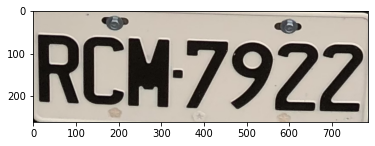

RCM7922


In [18]:
image = cv2.imread('../plate_detection/plate.png')
plt.imshow(image)
plt.show()

print(plate_ocr(image))

## 推論圖片

In [19]:
model = yolo()

In [20]:
# 這邊可以設定要設定為黑名單的車牌號碼
ban_list = ['AUS7790', 'ASA9767']

4HS58
AUS7790
plate:  2


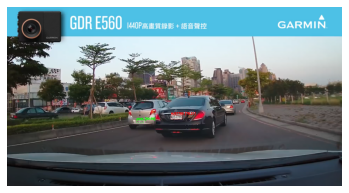

True

In [21]:
image = cv2.imread('../plate_detection/car.png')
image = process_image(image, model, ban_list)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.axis("off") 
plt.imshow(image)
plt.show()

cv2.imwrite('../plate_detection/car_demo.png', image_rgb)

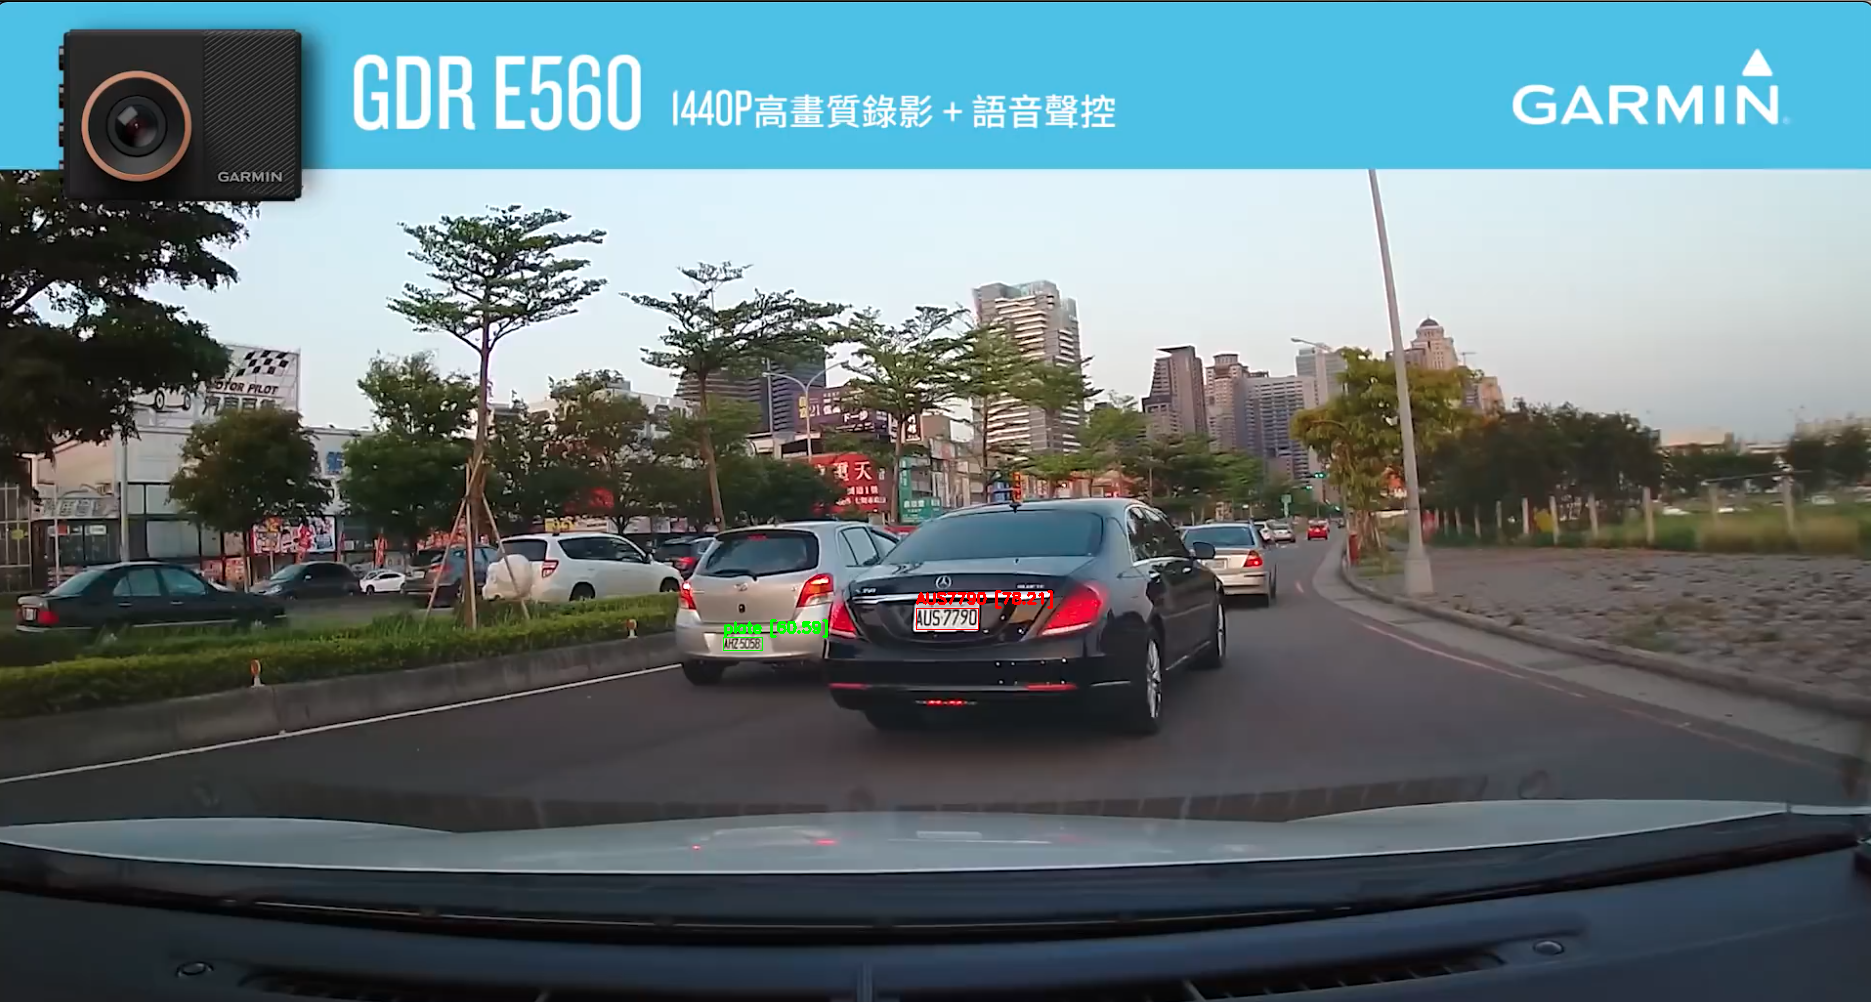

In [22]:
# 在 colab 上可以運行這格程式碼看大圖
from google.colab.patches import cv2_imshow 
cv2_imshow(image_rgb)

## 影片推論

In [ ]:
def set_saved_video(input_video, output_video, size):
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = int(input_video.get(cv2.CAP_PROP_FPS))
    video = cv2.VideoWriter(output_video, fourcc, fps, size)
    return video

In [ ]:
model = yolo()

In [ ]:
# 這邊可以設定要設定為黑名單的車牌號碼
ban_list = ['AUS7790', 'ASA9767']

In [ ]:
input_path = 'test_car_video.mp4'
output_path = 'test_car_video_demo.mp4'

In [ ]:
cap = cv2.VideoCapture(input_path)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

darknet_image = darknet.make_image(width, height, 3)

output_video = set_saved_video(cap, output_path, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    prev_time = time.time()

    if frame is None:
        break
    
    image = process_image(frame, model, ban_list)

    fps = int(1 / (time.time() - prev_time))
    print('fps: ', fps)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output_video.write(image)

    if cv2.waitKey(fps) == 27:
        break

cap.release()
output_video.release()
cv2.destroyAllWindows()

print('Done')